# Прогнозирование оттока клиентов для  оператора связи

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Задача проекта

Создать и обучить модель способную предсказывать уйдет ли клиент в ближайшее время.

Критерий оценки модели: метрика AUC-ROC должна быть больше 0,85.

## Исследовательский анализ данных 

### Загрузка библиотек

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import phik
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

Установим показатель `random_state`:

In [2]:
RANDOM_STATE = 60623

### Изучим данные

Загрузим данные:

In [3]:
contract_data = pd.read_csv('/datasets/contract_new.csv')

personal_data = pd.read_csv('/datasets/personal_new.csv')

internet_data = pd.read_csv('/internet_new.csv')

phone_data = pd.read_csv('/phone_new.csv')

Теперь изучим каждый датафрейм, создадим для этого функцию:

In [4]:
def info(date):
    display(date.head(5),
            date.info(),
            date.describe(),
            date.apply(lambda col: col.unique()))

Первый датафрейм - информация о договорах:

In [5]:
info(contract_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


customerID          [7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...
BeginDate           [2020-01-01, 2017-04-01, 2019-10-01, 2016-05-0...
EndDate             [No, 2017-05-01, 2016-03-01, 2018-09-01, 2018-...
Type                             [Month-to-month, One year, Two year]
PaperlessBilling                                            [Yes, No]
PaymentMethod       [Electronic check, Mailed check, Bank transfer...
MonthlyCharges      [29.85, 56.95, 53.85, 42.3, 70.7, 99.65, 89.1,...
TotalCharges        [31.04, 2071.84, 226.17, 1960.6, 353.5, 1150.9...
dtype: object

В этом датафрейме 8 столбцов и 7043 записи. Пропуски в данных отсутствуют. В нем присутствует столбец EndDate, из которого создадим столбец с целевым признаком. Столбец `TotalCharges` нужно перевесть в формат float, сначала проверим, почему он не в этом формате:

In [6]:
contract_data.sort_values(by='TotalCharges').head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,


В данных вместо нулевого значения стоят пробелы у клиентов, кто только заключил контракт, поэтому заменим эти пробелы на нули:

In [7]:
contract_data['TotalCharges'] = contract_data['TotalCharges'].str.replace(' ', '0').astype(float)

Теперь изучим датафрейм - личные данные:

In [8]:
info(personal_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


customerID       [7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...
gender                                              [Female, Male]
SeniorCitizen                                               [0, 1]
Partner                                                  [Yes, No]
Dependents                                               [No, Yes]
dtype: object

В этом датафрейме 5 столбцов и 7043 записи, количество записей совпадает в количеством записей в базе данных договоров, значит для каждого контракта есть информация о клиенте. Пропуски в данных отсутствуют.

Изучим датаферйм с информацией об интернет услугах:

In [9]:
info(internet_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


customerID          [7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...
InternetService                                    [DSL, Fiber optic]
OnlineSecurity                                              [No, Yes]
OnlineBackup                                                [Yes, No]
DeviceProtection                                            [No, Yes]
TechSupport                                                 [No, Yes]
StreamingTV                                                 [No, Yes]
StreamingMovies                                             [No, Yes]
dtype: object

В этом датафрейме 8 столбцов и 5517 записей, количество записей меньше чем число контрактов, значит не у всех клиетов заключены  договоры на интернет услуги. Пропуски в данных отсутствуют.

Теперь изучим датафрей с информацией об услугах телефонии:

In [10]:
info(phone_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


customerID       [5575-GNVDE, 3668-QPYBK, 9237-HQITU, 9305-CDSK...
MultipleLines                                            [No, Yes]
dtype: object

В этом датафрейме 2 столбца и 6361 записей, количетсво записей не совпадает с количеством клиентов. Пропусков нет.

### Объединение таблиц

Объединим все датафреймы в один. Пропуски для клиентов без интернета заполним как `NoInternet`, для клиентов без договоров телефонии как `NoPhone`.

In [11]:
full_data = contract_data.merge(personal_data,how ='left').merge(internet_data, how ='left').fillna('NoInternet').merge(phone_data, how = 'left').fillna('NoPhone')

In [12]:
full_data.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NoPhone
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NoPhone
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


### Создание признаков

Теперь нужно создать необходимые признаки для обучения модели:

Сначала столбец с количеством дней, которые клиент пользуется услугами `Duration`:

In [13]:
def cat1(x,y):
    if x == 'No':
        return dt.strptime('2020-02-01', '%Y-%m-%d').date() - dt.strptime(y, '%Y-%m-%d').date()
    return dt.strptime(x, '%Y-%m-%d').date() - dt.strptime(y, '%Y-%m-%d').date()

full_data['Duration'] = full_data.apply(lambda x: cat1(x['EndDate'], x['BeginDate']), axis=1).dt.days

И столбец с целевым параметром `Target`:

In [14]:
def cat2(x):
    if x == 'No':
        return 0
    return 1

full_data['Target'] = full_data['EndDate'].apply(cat2)

Теперь удалим столбцы, которые больше не понадобятся:

In [15]:
full_data = full_data.drop(['customerID','BeginDate','EndDate'], axis = 1)

Проверим на дубликаты и удалим их:

In [16]:
full_data.duplicated().sum()

4

In [17]:
full_data = full_data.drop_duplicates()
full_data.duplicated().sum()

0

### Вывод по исследовательскому анализу данных и план работы

Мы изучили предоставленные данные, проверили на пропуски, объединили их в один датафрейм, создали новые признаки, удалили лишние столбцы и дубликаты.

**План работы:**
  - Разбить данные на признаки и целевой признак
  - Определить какие признаки оставить, а какие удалить через SHAP и проверку на мультиколлинеарность
  - Разбить данные на две выборки - тренировочную и тестовую
  - Используя кросс-валидацию (GridSearchCV) обучить и проверить три модели - модели случайного леса, модели LightGBM и CatBoost
  - Проверить показатель AUC ROC модели показавшей себя лучше в предыдущем пункте на тестовой выборке

## Создание моделей

### Изучим обединенный датасет

Перед тем как обучать модели, необходимо изучить признаки, их корреляцию и значимость.

Сначала построим гистограммы распределения признаков для ушедших клиентов и клиентов оставшихся. График с подписью `0` - клиент остался, `1` - клиент ушел:

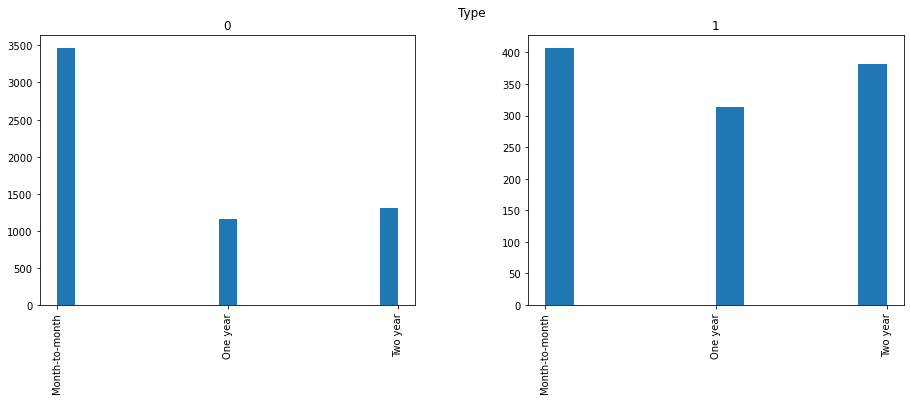

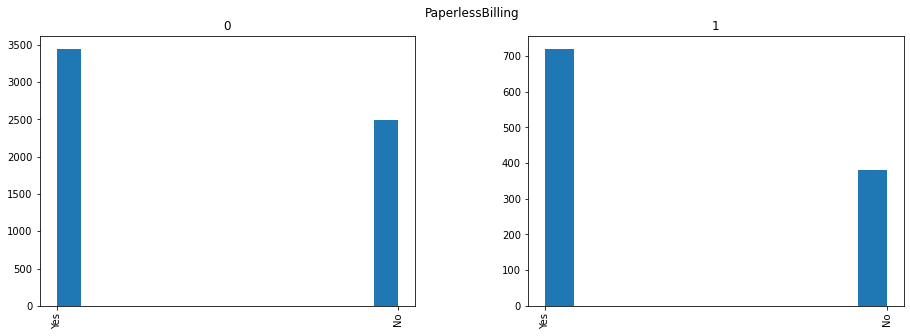

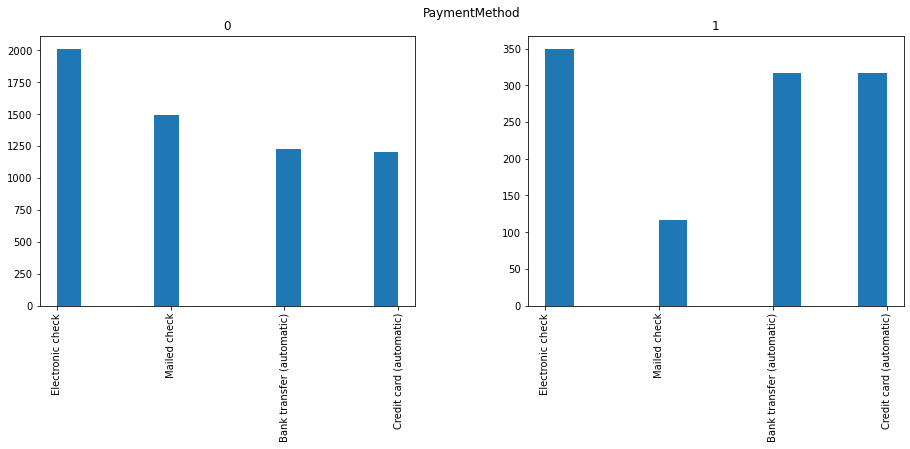

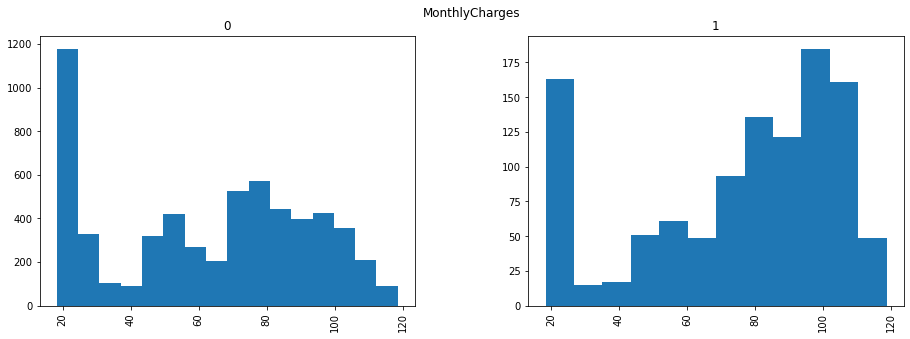

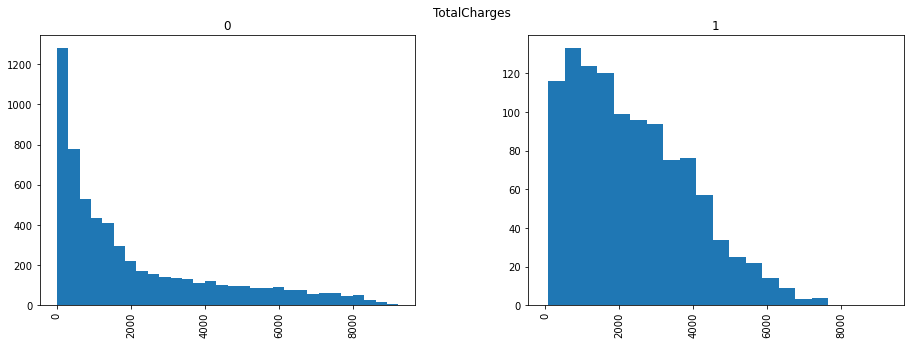

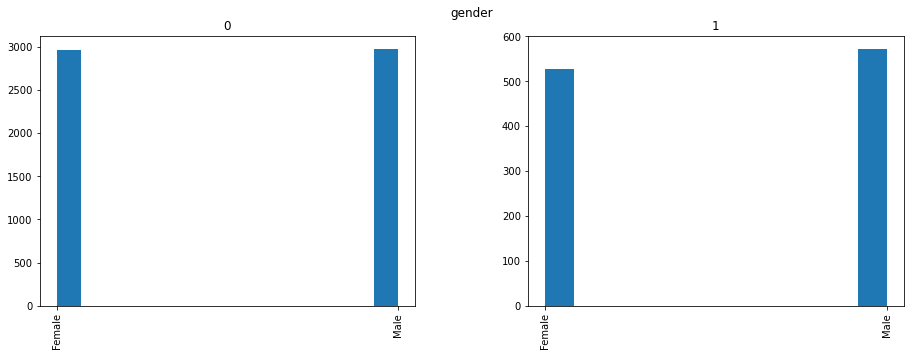

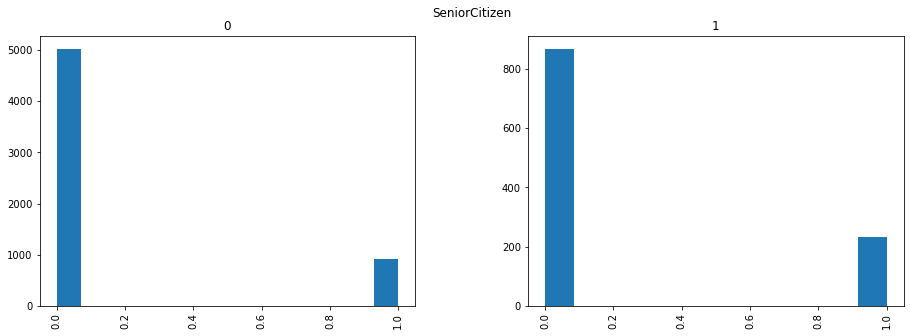

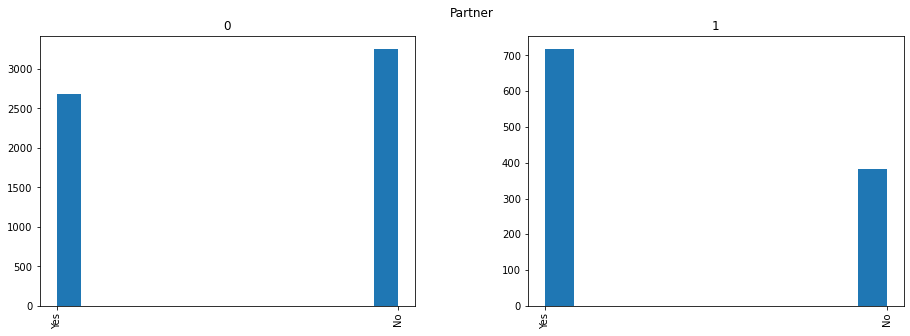

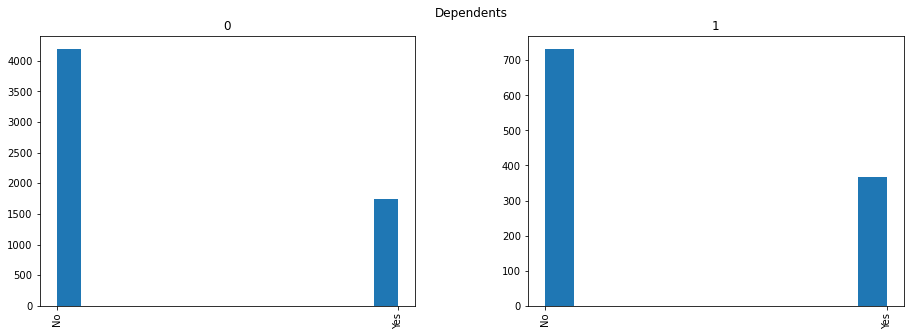

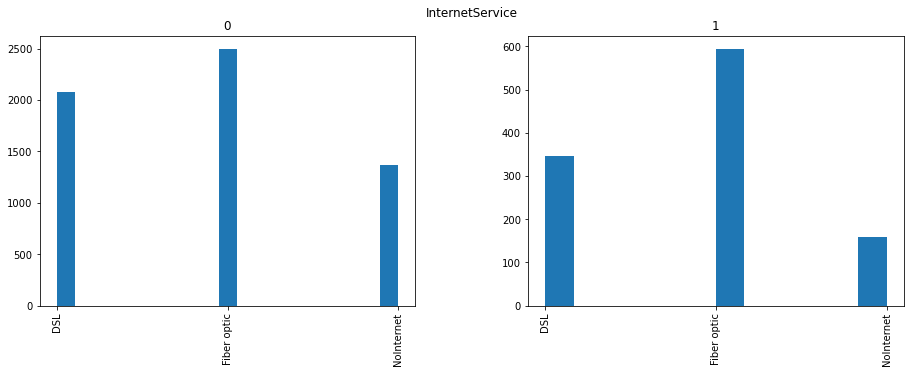

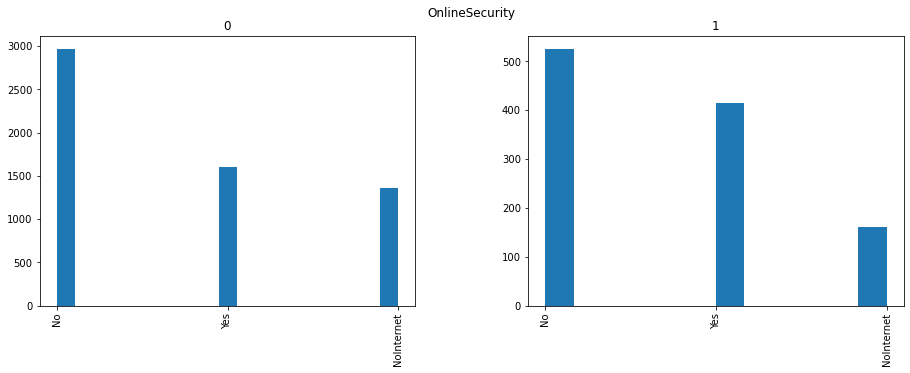

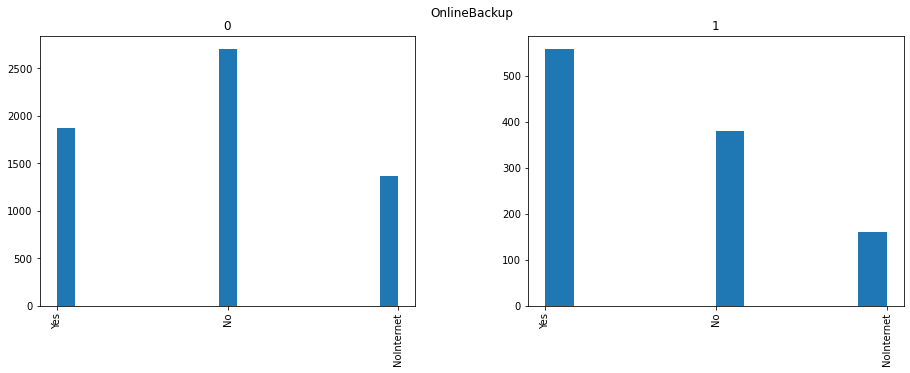

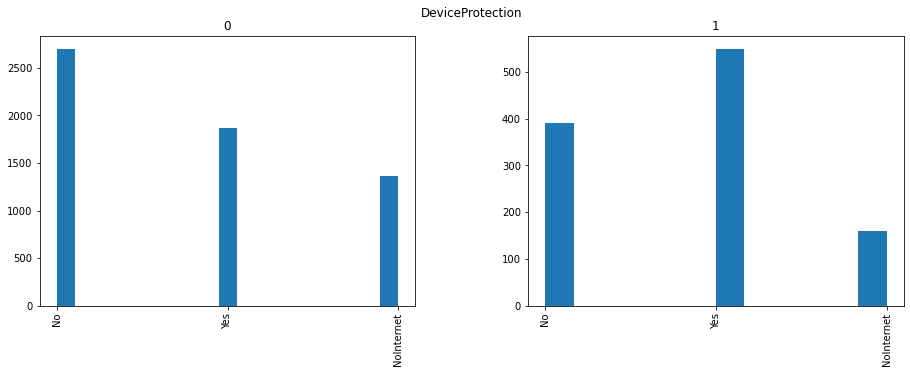

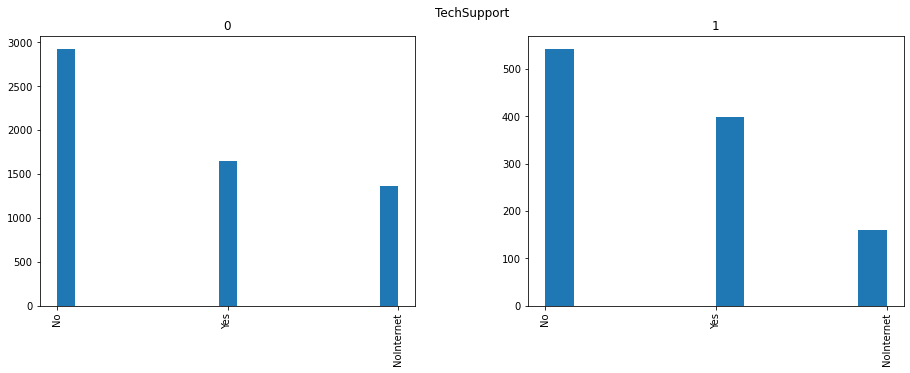

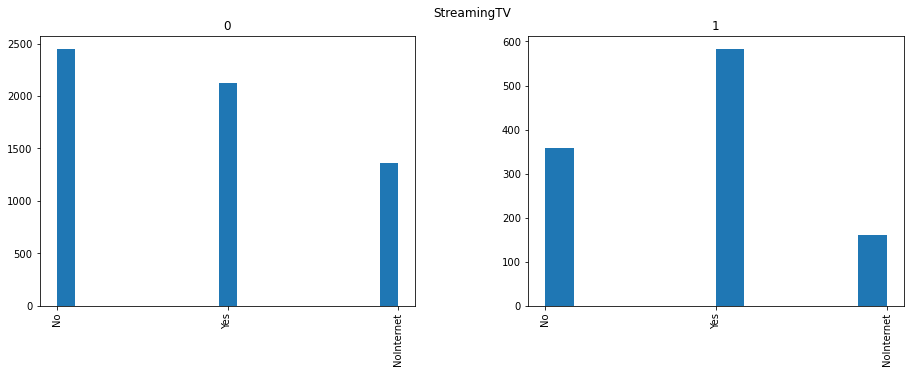

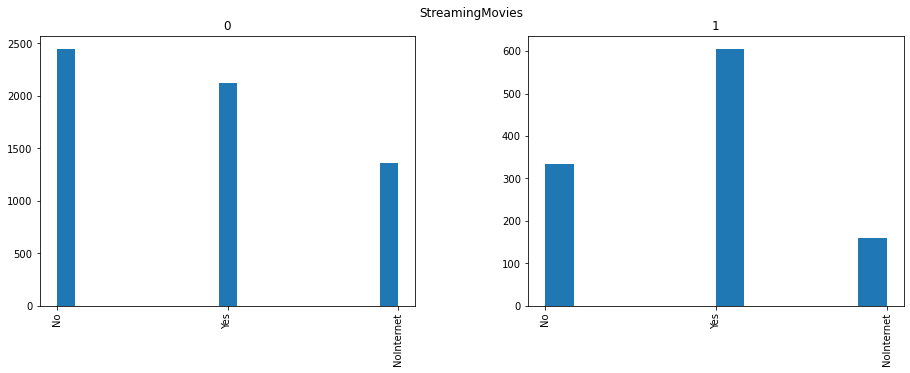

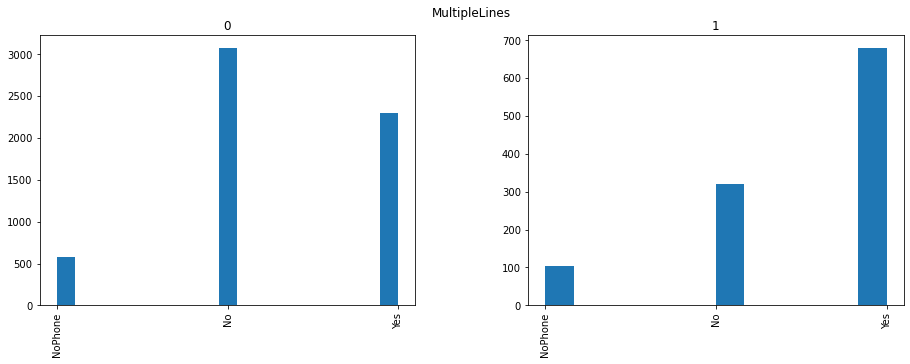

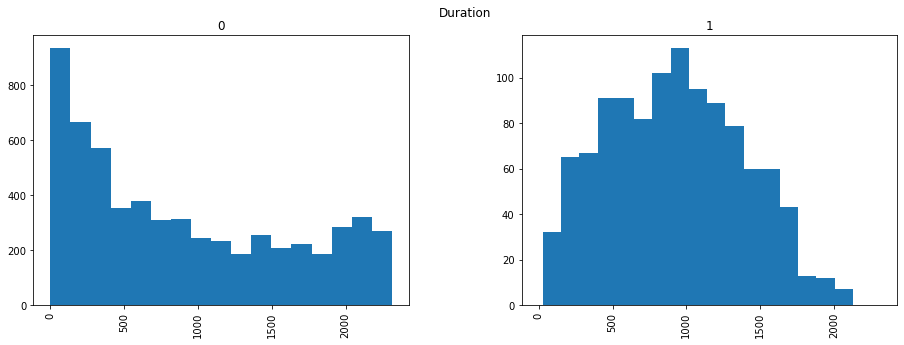

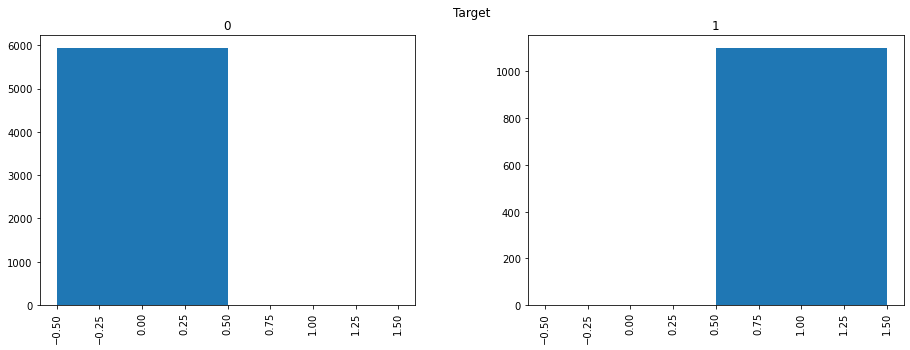

In [18]:
for col in full_data.columns:
    full_data.hist(column = col, by = 'Target', figsize=(15,5), sharex=True, bins='auto');
    plt.suptitle(col);

Что можно узнать из графиков:

    1) Среди ушедших клиентов меньше тех, чей договор заключается ежемесячно

    2) Ушедшие клиенты меньше выбирали оплату через отравку чека по почте

    3) Доля ушедших клиентов, которая платила больше чем 80 долларов в месяц выше, чем у оставшихся

    4) Доля тех, кто за все время потратил меньше 2000 долларов меньше среди  ушедших клиентов, чем среди оставшихся

    5) У ушедших клиентов больше шансов, что есть супруг(а)

    6) Среди ушедших клиентов больше тех, кто заказывал услугу резервного копирования данных, услуги антивируса (DeviceProtection), а так же стриминговое телевидение (StreamingTV), каталог фильмов (StreamingMovies) и услугу параллельных телефонных линий (MultipleLines)

    7) Среди ушедших клиентов преобладают те, кто был клиентом больше года, в то время как среди оставшихся пик приходится на тех, кто меньше года.

    8) Осталось около 6000 клиентов, ушло около 1000

    9) По другим параметрам разнице не настолько заметна

Вывод: 

Можно предположить, что уходят клиенты, у которых есть история использования сервисами, возможно стоимость их тарифов за все время не обновлялась (поэтому больше ежемесячных затрат) и они ушли к конкурентам с более выгодными предложениями. Возможно у конкурентов лучше предложения по пакетам услуг включающие антивирус, стримминговое ТВ и т.д.

### Проверка на мультиколлинеарность

Теперь проверим наши данные на мультиколлинеарность, сначала посчитав коэффициент корреляции Пирсона:

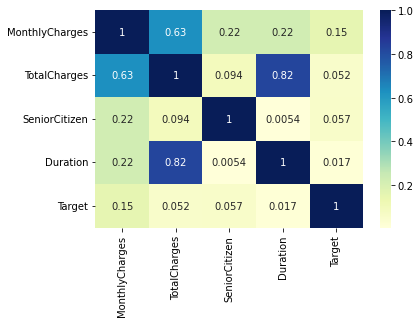

In [19]:
df_plot = sns.heatmap(full_data.corr(), cmap="YlGnBu", annot=True)   
plt.show()

Между столбцами TotalCharges и столбцами Duration и MonthlyCharges высокие показатели корреляции, поэтому удалим столбец TotalCharges.

Перед этим проверим данные на мультиколлинеарность через Phik, чтобы захватить и категориальные признаки:

Перед этим установим числовые столбцы:

In [20]:
numerical_features = ['MonthlyCharges', 'TotalCharges', 'Duration']

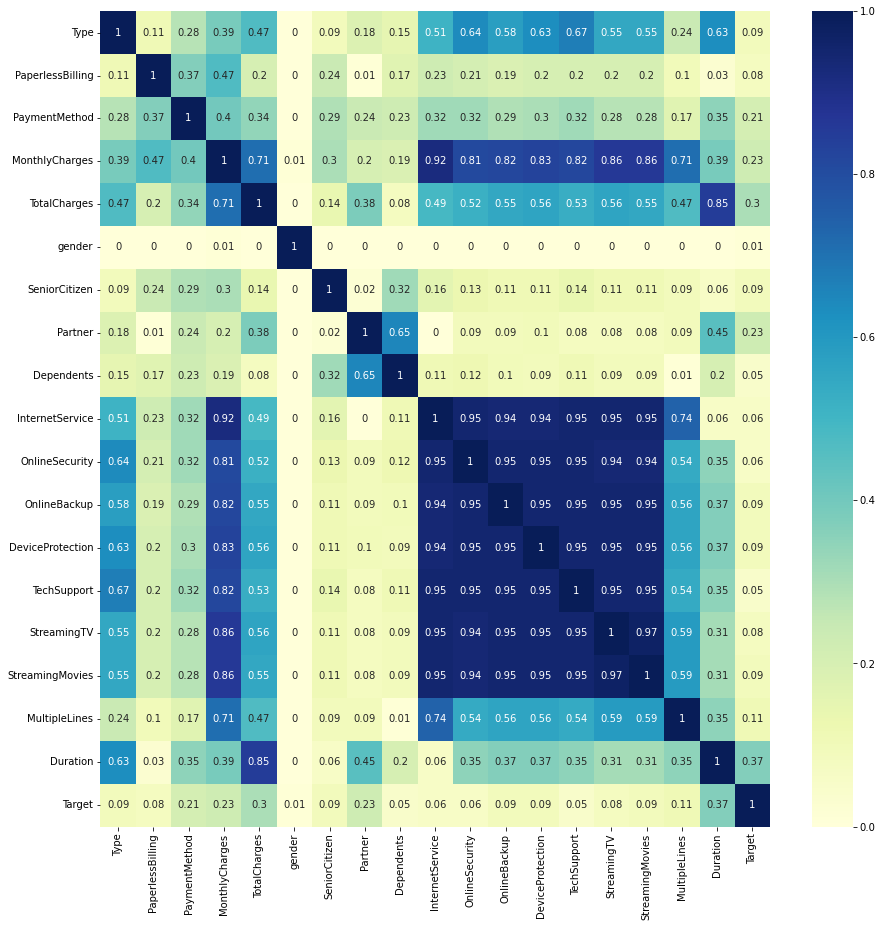

In [21]:
pm = full_data.phik_matrix(interval_cols=numerical_features)
plt.figure(figsize=(15,15))
df_plot = sns.heatmap(pm.round(2), cmap="YlGnBu", annot=True, )   
plt.show()

Заметна высокая корреляция среди всех столбцов с интернет-услугами, а так же типом интернет услуг и месячной оплатой. Пока удалять эти столбцы не будем, так как не будем обучать линейные модели. Удалим только столбец с общими расходами.

In [22]:
full_data = full_data.drop('TotalCharges', axis=1)

### Создание выборок

Выделим в данных целевой признак и разобьем выборки на учебную и тестовую выборки:

In [23]:
target = full_data['Target']
features = full_data.drop('Target', axis=1)

In [24]:
features_train, features_test, target_train, target_test, = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

Выборки созданы, можно обучать модели.

### Модель случайного леса (RandomForestClassifier)

Подготовим модель случайного леса.

Для нее закодируем категориальные признаки, сначала выделим их:


In [25]:
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod','gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

Теперь создадим кодировщик:

In [26]:
OHE = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

Теперь создадим пайплайн, в который добавим наш кодировщик и нашу модель:

In [27]:
rfc = Pipeline(steps=[('preprocessor', make_column_transformer((OHE, categorical_features), 
                                                               remainder='passthrough', 
                                                               verbose_feature_names_out=False)),
                      ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))])

Теперь используя GridSearchCV подберем лучшие параметры для модели:

In [28]:
param_grid = {
    'classifier__n_estimators': [800,900,1000],
    'classifier__max_depth':range(5,11),
    'classifier__class_weight':[None, 'balanced']
}

grid_search = GridSearchCV(rfc, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=3)

grid_search.fit(features_train, target_train)

print(('\n\n\033[1mЛучший показатель AUC ROC модели случайного леса: %.3f'
       % grid_search.best_score_), '\n\nС параметрами модели:', grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


Лучший показатель AUC ROC модели случайного леса: 0.823 

С параметрами модели: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 7, 'classifier__n_estimators': 900}


**Модель случайного леса показала результат: 0,823**

Модель показала результат ниже необходимого 0,85, попробуем другую модель.

### Модель LightGBM 

Подготовим модель:

In [29]:
lgbm = LGBMClassifier(random_state=RANDOM_STATE)

Для нее необходимо перевесть тип данных в категориальный:

In [30]:
for c in categorical_features:
    features_train[c] = features_train[c].astype('category')

Используя GridSearchCV так же подберем лучшие гиперпараметры:

In [31]:
param_grid = {
    'class_weight': [None, 'balanced'],
    'max_depth': range(1,6),
    'n_estimators':range(1500, 1600, 10)
}

grid_search = GridSearchCV(lgbm, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=3)

grid_search.fit(features_train, target_train)

print(('\n\n\033[1mЛучший показатель AUC ROC модели LightGBM: %.3f'
       % grid_search.best_score_), '\n\nС параметрами модели:', grid_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


Лучший показатель AUC ROC модели LightGBM: 0.904 

С параметрами модели: {'class_weight': None, 'max_depth': 2, 'n_estimators': 1560}


**Модель LightGBM показала результат: 0,904**

Это хороший результат, подходит для дальнейшей работы.

### Модель CatBoost:

Подготовим модель CatBoost:

In [32]:
catclass = CatBoostClassifier(random_state=RANDOM_STATE, cat_features=categorical_features, learning_rate=0.03)

Подберем гиперпараметры:

In [33]:
param_grid = {
    'depth': range(4,11),
    'iterations':range(1300, 1500, 100)
}

grid_search = GridSearchCV(catclass, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)

grid_search.fit(features_train, target_train)
print(('\n\n\033[1mЛучший показатель AUC ROC модели CatBoost: %.3f'
       % grid_search.best_score_), '\n\nС параметрами модели:', grid_search.best_params_)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
0:	learn: 0.6688190	total: 187ms	remaining: 4m 22s
1:	learn: 0.6487344	total: 217ms	remaining: 2m 31s
2:	learn: 0.6280550	total: 250ms	remaining: 1m 56s
3:	learn: 0.6080808	total: 300ms	remaining: 1m 44s
4:	learn: 0.5886228	total: 336ms	remaining: 1m 33s
5:	learn: 0.5697933	total: 372ms	remaining: 1m 26s
6:	learn: 0.5516564	total: 410ms	remaining: 1m 21s
7:	learn: 0.5379441	total: 445ms	remaining: 1m 17s
8:	learn: 0.5271579	total: 472ms	remaining: 1m 13s
9:	learn: 0.5156054	total: 507ms	remaining: 1m 10s
10:	learn: 0.5061308	total: 527ms	remaining: 1m 6s
11:	learn: 0.4940438	total: 561ms	remaining: 1m 4s
12:	learn: 0.4853163	total: 595ms	remaining: 1m 3s
13:	learn: 0.4785348	total: 617ms	remaining: 1m 1s
14:	learn: 0.4730819	total: 625ms	remaining: 57.7s
15:	learn: 0.4647108	total: 660ms	remaining: 57.1s
16:	learn: 0.4557926	total: 694ms	remaining: 56.5s
17:	learn: 0.4515094	total: 703ms	remaining: 53.9s
18:	learn: 0.4443917	

**Модель CatBoost показала результат:  0,885**

Результат лучше, чем необходимый 0,85, но хуже чем у LightGBM.

**Итог:**

Мы обучили на тренировочной выборке и настроили три модели (RandomForestClassifier, LightGBM и CatBoost), из которых лучший результат показала модель LightGBM с параметрами `class_weight`: None, `max_depth`: 2, `n_estimators`: 1560. Ее результат метрики AUC ROC на кросс-валидации составил 0,904.

### Проверка лучшей модели

Теперь можем проверить лучшую модель с лучшими гиперпараметрами на тестовой выборке:

In [34]:
for c in categorical_features:
    features_test[c] = features_test[c].astype('category')

In [35]:
lgbm_best = LGBMClassifier(random_state=RANDOM_STATE, class_weight=None, max_depth=2, n_estimators=1560)

lgbm_best.fit(features_train, target_train)

print('\033[1mЗначение AUC ROC для модели LightGBM на тестовой выборке: %.3f'
       % roc_auc_score(target_test, lgbm_best.predict_proba(features_test)[:, 1]))

Значение AUC ROC для модели LightGBM на тестовой выборке: 0.923


Лучшая модель проверку прошла.

### Исследование важности признаков

Исследуем важность признаков, для возможного улучшения модели:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


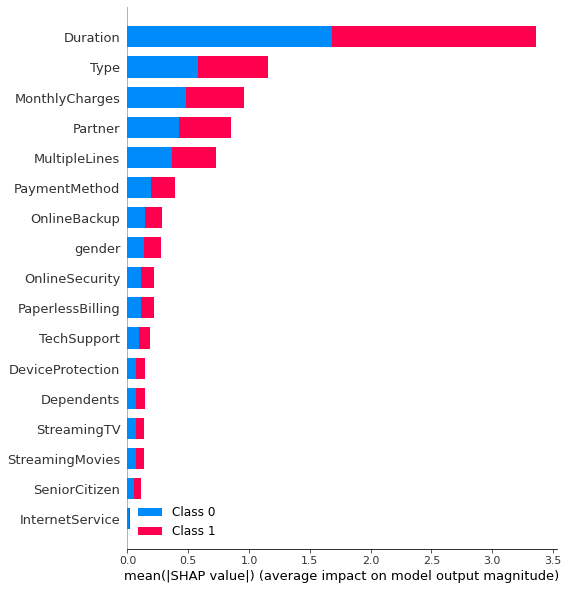

In [36]:
shap_test = shap.TreeExplainer(lgbm_best).shap_values(features_train)

shap.summary_plot(shap_test, features_train,
                      max_display=25)

Как видно из графика на результат совсем не повлиял столбец `InternetService`, значит можно его удалить в дальнейшей работе.

### Построим матрицу ошибок

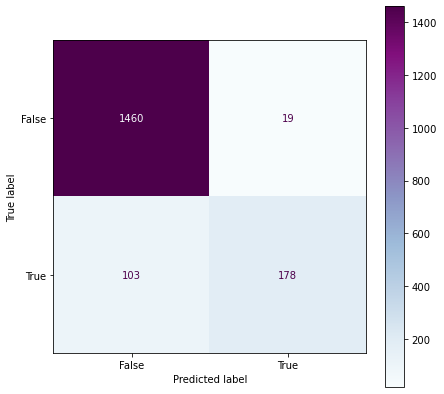

In [37]:
cm = confusion_matrix(target_test, lgbm_best.predict(features_test))

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

fig, ax = plt.subplots(figsize=(7,7))
cm_display.plot(ax=ax, cmap='BuPu')
plt.show();

Матрица связана с нашим показателем AUC ROC, так как отображает связанные с ним значения истинно положительных и ложно положительных предсказанных значений. Из графика видно, как и когда удалось предсказать верно, а где были допущены ошибки. 

## Отчет по проекту

**Выполнение плана работы:**
- Мы изучили данные, объединили датафреймы и проверили их на дубликаты и пропуски
- Мы создали и выделили в объединенном датафрейме целевой признак `Target`, показывающий ушел клиент или нет, так же создали признак `Duration`. После этого удалили больше ненужные признаки `customerID`,`BeginDate`,`EndDate`
- Провели анализ данных в разрезе целевого признака, высказали предположения о причине ухода клиентов
- Проверили признаки на мультиколлинеарность, удалили сильно коррелирующий признак `TotalCharges` из выборки 
- Выделили тестовую выборку из данных (25%)
- Мы обучили и методом кросс-валидации настроили и проверили три модели:

        1)Модель случайного леса - на кросс-валидации метрика AUC ROC 0.823, недостаточная для наших целей
        
        2)Модель LightGBM - на кросс-валидации метрика AUC ROC 0.904
        
        3)Модель CatBoost - на кросс-валидации метрика AUC ROC 0.885
- Показавшая лучшие результаты модель LightGBM, была проверена на тестовой выборке и ее метрика AUC ROC на тесте равна 0.923
- Провели исследование матрицы признаков и нашли, что признак `InternetService` не влияет на результаты модели
- Изучили как показывает себя модель на тестовой выборке с помощью матрицы ошибок



**ВЫВОД:**

**Лучшая модель:** LightGBM Classifier


**Признаки обучения для лучшей модели:**

Модель была обучена на следующих признаках:

`Type`, `PaperlessBilling`, `PaymentMethod`, `MonthlyCharges`, `gender`,`SeniorCitizen`, `Partner`, `Dependents`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines`, `Duration`

В дальнейшем возможно удаление из выборок признака `InternetService`, так как установленно, что он не влиял на результат

**Гиперпараметры лучшей модели:**

`class_weight`: None

`max_depth`: 2

`n_estimators`: 1560

**Качество модели:** метрика AUC ROC **0.904** на кросс-валидации и  **0.923** на тестовой выборке